# 비트코인 어떤걸사고 언제팔까

## 개요
**전략** : 120분 중 가격이 최대인 위치(argmax)와 그때의 가격(max) 예측, 이때 X는 open, volume, trades 3개의 변수를 이용했고, 1380분의 데이터를 10개씩 잘라 평균값을 사용했다. X는 138x3=414개의 column을 가지고있다.<br>
**과정**<br>
1. Train, Validation, Test data 분리
2. Train data로 LGBM을 이용해 argmax, max를 예측하는 모델 생성(이때 모델의 파라미터는 Validation data의 mse를 최소화하는 방향으로
3. Test data를 이용해 투자수익 계산(max를 1.015초과로 예측한 sample_id에서 argmax의 위치에 판매하는 전략<br>
**개선방향**<br>
- 코인 구매 비중을 1이아니라 max를 예상한 값의 비율로 설정
- 1380분의 데이터를 10등분해서 평균을 사용했는데, 그냥 최근 n일 데이터를 사용할 수 있음. 이러면 학습데이터양도 증가


In [1]:
# 구글 드라이브와 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 기본 라이브러리
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

In [12]:

# 모델링 관련
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

import lightgbm as lgb

In [3]:
# plotting 관련
import cufflinks as cf
import plotly.offline
cf.go_offline()
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
os.chdir('./drive/MyDrive/projects/coin')  # 현재 폴더 위치 변경

In [7]:
# # 일부 데이터만 불러오기
# nrow = 500
# train_x = pd.read_csv('./open/train_x_df.csv', nrows=1380 * nrow)
# train_y = pd.read_csv('./open/train_y_df.csv', nrows=120 * nrow)
train_x = pd.read_csv('./open/train_x_df.csv')
train_y = pd.read_csv('./open/train_y_df.csv')

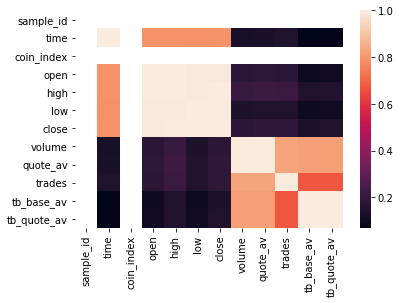

In [8]:
sns.heatmap(train_x[train_x['sample_id'] == 0].corr())

OHLC끼리 연관이 있고, Volume끼리도 연관이 있음 -> open, volume trades 3개 변수만 사용하자

In [9]:
def mm(arr):
  """
  min max scaling
  """
  return (arr - min(arr))/ (max(arr) - min(arr))


def flatten(df):
  """
  1380 x 3을 flatten 하는 과정
  """
  df_flattened = np.array(df.loc[:,['open', 'volume', 'trades']]).reshape(len(df)//1380, 1380, 3)
  for i in range(len(df_flattened)):
      for j in range(3):
          df_flattened[i][:,j] = mm(df_flattened[i][:,j])
  df_flattened = df_flattened.reshape(len(df) // 1380, 1380, 3)
  return df_flattened


def grouping(arr, n):
  """
  10개씩 끊어 평균을 저장하는 과정
  """
  result = []
  cnt = len(arr) // n
  for i in range(cnt):
    result.append(np.mean(arr[10*i:10*(i+1)]))
  return result

In [11]:
def preprocess_x(df):
  df_flattened = flatten(df)
  X = []
  for i in tqdm(range(len(df_flattened))):
    temp = []
    for j in range(3):
      temp.extend(grouping(df_flattened[i].T[j], 10))
    X.append(temp)
  X = pd.DataFrame(X)
  return X

In [23]:
def preprocess_y(df):
  y_max = {'max':[], 'argmax': []}

  for i in tqdm(range(df['sample_id'].unique().max()+1)):
      y_max['max'].append(df[df['sample_id'] == i]['open'].max())
      y_max['argmax'].append(df[df['sample_id'] == i]['open'].argmax())
  y_max['max'] = np.array(y_max['max'])
  y_max['argmax'] = np.array(y_max['argmax'])
  return y_max

In [18]:
X = preprocess_x(train_x)

100%|██████████| 7661/7661 [00:30<00:00, 248.95it/s]


In [24]:
y = preprocess_y(train_y)

100%|██████████| 7661/7661 [00:31<00:00, 246.98it/s]


In [25]:
y_argmax = y_max['argmax']
y_max = y_max['max']

In [26]:
X_train, X_test, y_train, y_test, y_train_max, y_test_max = train_test_split(X, y_argmax, y_max, test_size=0.2, random_state=2021)

In [27]:
X_train, X_valid, y_train, y_valid, y_train_max, y_valid_max = train_test_split(X_train, y_train, y_train_max, test_size=0.2, random_state=2021)

In [28]:
X_train.shape

(4902, 414)

## DNN 모델

In [29]:
model = keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1], )),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

In [30]:
np.mean((y_valid - np.mean(y_valid)) ** 2)  # 그냥 y_valid의 평균으로 예측한 mse -- baseline

1709.8262449802935

In [31]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])
model.fit(X_train, y_train, epochs=30, verbose=1, batch_size=10, validation_data=(X_valid, y_valid))

Epoch 1/30
491/491 [==============================] - 5s 4ms/step - loss: 2235.3957 - mse: 2235.3957 - val_loss: 1826.1746 - val_mse: 1826.1746
Epoch 2/30
491/491 [==============================] - 2s 3ms/step - loss: 1760.6745 - mse: 1760.6745 - val_loss: 1781.7390 - val_mse: 1781.7390
Epoch 3/30
491/491 [==============================] - 2s 3ms/step - loss: 1758.4225 - mse: 1758.4225 - val_loss: 1845.9608 - val_mse: 1845.9608
Epoch 4/30
491/491 [==============================] - 2s 3ms/step - loss: 1736.7879 - mse: 1736.7879 - val_loss: 1743.1134 - val_mse: 1743.1134
Epoch 5/30
491/491 [==============================] - 2s 3ms/step - loss: 1712.9548 - mse: 1712.9548 - val_loss: 1805.0039 - val_mse: 1805.0039
Epoch 6/30
491/491 [==============================] - 2s 3ms/step - loss: 1730.4051 - mse: 1730.4052 - val_loss: 1739.8868 - val_mse: 1739.8866
Epoch 7/30
491/491 [==============================] - 2s 3ms/step - loss: 1680.7257 - mse: 1680.7257 - val_loss: 1731.8540 - val_mse: 17

- train mse는 줄어들지만 validation data의 mse는 줄어들지않음 -> overfitting

In [32]:
# dropout이랑 learning rate, epoch 약간 조정한 모델
def DNN(X_train, y_train, X_valid, y_valid):
  model = keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(X_train.shape[1], )),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(1)
  ])
  adam = keras.optimizers.Adam(lr=0.0005)
  model.compile(optimizer=adam,
                loss='mse',
                metrics=['mse'])

  model.fit(X_train, y_train, epochs=16, verbose=1, batch_size=10, validation_data=(X_valid, y_valid))
  return model

In [33]:
model = DNN(X_train, y_train, X_valid, y_valid)

Epoch 1/16
491/491 [==============================] - 3s 4ms/step - loss: 2367.6774 - mse: 2367.6774 - val_loss: 1796.3990 - val_mse: 1796.3990
Epoch 2/16
491/491 [==============================] - 2s 4ms/step - loss: 1812.8544 - mse: 1812.8544 - val_loss: 1766.2953 - val_mse: 1766.2953
Epoch 3/16
491/491 [==============================] - 2s 4ms/step - loss: 1768.9430 - mse: 1768.9430 - val_loss: 1758.4784 - val_mse: 1758.4784
Epoch 4/16
491/491 [==============================] - 2s 4ms/step - loss: 1805.2149 - mse: 1805.2149 - val_loss: 1756.0671 - val_mse: 1756.0671
Epoch 5/16
491/491 [==============================] - 2s 4ms/step - loss: 1742.4938 - mse: 1742.4938 - val_loss: 1743.7552 - val_mse: 1743.7552
Epoch 6/16
491/491 [==============================] - 2s 4ms/step - loss: 1791.1094 - mse: 1791.1094 - val_loss: 1748.5824 - val_mse: 1748.5824
Epoch 7/16
491/491 [==============================] - 2s 4ms/step - loss: 1727.8795 - mse: 1727.8795 - val_loss: 1743.2911 - val_mse: 17

이거도 별로(val_mse가 1709보다는 낮아야된다)

## Plotting
실제 argmax의 분포와 argmax 예측 분포

In [35]:
pred = model.predict(X_valid).flatten()

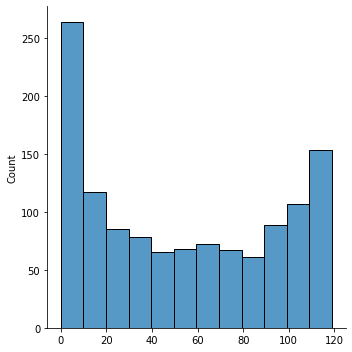

In [36]:
sns.displot(y_valid);  # 실제 argmax 분포

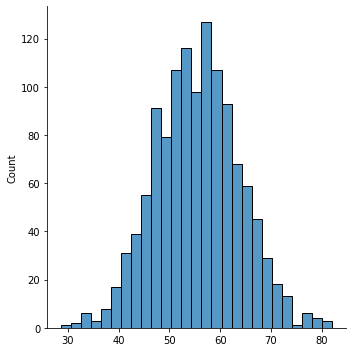

In [37]:
sns.displot(pred);  # 예상 argmax 분포

평균(55) 중심으로 예측을 한다.

## LGBM
https://nicola-ml.tistory.com/51<br>
https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [38]:
def LGBM(X_train, y_train, X_valid, y_valid, it):
  train_ds = lgb.Dataset(X_train, label = y_train) 
  valid_ds = lgb.Dataset(X_valid, label = y_valid) 
  params = {'learning_rate': 0.005,   # default is 0.001
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 100,   # default is 31
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          # 'max_cat_group': 10,  # default is 64
          'seed':2021}
  model = lgb.train(params, train_ds, it, valid_ds, verbose_eval=100, early_stopping_rounds=100)
  return model

In [39]:
model = LGBM(X_train, y_train, X_valid, y_valid, 1000)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1698
[200]	valid_0's l2: 1693.62
[300]	valid_0's l2: 1693.03
Early stopping, best iteration is:
[207]	valid_0's l2: 1692.63


In [40]:
pred = model.predict(X_valid)

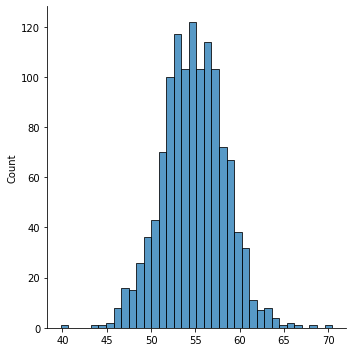

In [41]:
sns.displot(pred)

이거도 마찬가지로 평균을 중심으로 예측

## pred의 극단값에서 실제 argmax값들은 유의미한 차이를 보일지

In [ ]:
sum(pred > 60)

76

In [ ]:
np.mean(y_valid)

53.76101141924959

In [ ]:
np.mean(y_valid[pred > 60])

62.46052631578947

In [ ]:
np.mean(y_valid[pred < 50])

44.10377358490566

어느정도는 의미가있다

## argmax말고 max

In [42]:
y_train_max

array([1.00746   , 1.00357962, 1.01142848, ..., 1.00632513, 1.00325048,
       1.00082004])

In [43]:
model = DNN(X_train, y_train_max, X_valid, y_valid_max)

Epoch 1/16
491/491 [==============================] - 3s 4ms/step - loss: 0.0721 - mse: 0.0721 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 2/16
491/491 [==============================] - 2s 4ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 3/16
491/491 [==============================] - 2s 3ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 4/16
491/491 [==============================] - 2s 4ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 2.8341e-04 - val_mse: 2.8341e-04
Epoch 5/16
491/491 [==============================] - 2s 3ms/step - loss: 4.3271e-04 - mse: 4.3271e-04 - val_loss: 2.1202e-04 - val_mse: 2.1202e-04
Epoch 6/16
491/491 [==============================] - 2s 4ms/step - loss: 3.0217e-04 - mse: 3.0217e-04 - val_loss: 1.8686e-04 - val_mse: 1.8686e-04
Epoch 7/16
491/491 [==============================] - 2s 4ms/step - loss: 2.3057e-04 - mse: 2.3057e-04 - val_loss: 2.4371e-04 - val_mse: 2.4371e-04
Epoch 8/16
491/491 [

In [44]:
np.mean((y_valid_max - np.mean(y_valid_max)) ** 2)  # 평균으로 예측했을때 mse

0.00018284616055955742

딥러닝은 별로 -- 데이터의 사이즈가 작아서그런가

In [45]:
model = LGBM(X_train, y_train_max, X_valid, y_valid_max, 1000)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.000175731
[200]	valid_0's l2: 0.000173446
[300]	valid_0's l2: 0.000172971
Early stopping, best iteration is:
[260]	valid_0's l2: 0.00017286


LGBM으로 가자

이건 max의 분포

In [46]:
pred = model.predict(X_valid)

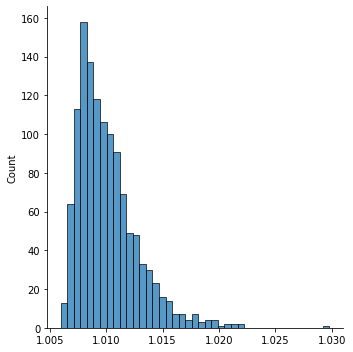

In [47]:
sns.displot(pred)

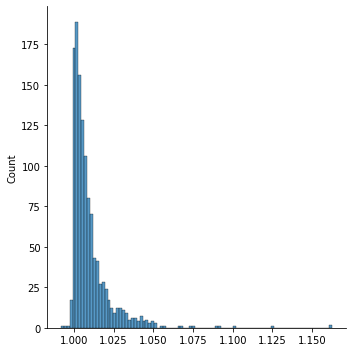

In [48]:
sns.displot(y_valid_max)

In [49]:
sum(pred > 1.015)

63

In [50]:
np.mean(y_valid_max[pred > 1.015])

1.0186749422360981

In [51]:
np.mean(y_valid_max)

1.0097173004127054

## Test

### train + valid

In [52]:
X_train_ = X_train.append(X_valid)
y_train_ = np.array(y_train.tolist() + y_valid.tolist())
y_train_max_ = np.array(y_train_max.tolist() + y_valid_max.tolist())

In [53]:
model_argmax = LGBM(X_train, y_train, X_train, y_train, 207)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1334.84
[200]	valid_0's l2: 1071.46
Did not meet early stopping. Best iteration is:
[207]	valid_0's l2: 1056.69


In [54]:
model_max = LGBM(X_train, y_train_max, X_train, y_train_max, 260)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.000186665
[200]	valid_0's l2: 0.000161672
Did not meet early stopping. Best iteration is:
[260]	valid_0's l2: 0.000150272


In [55]:
pred_argmax = model_argmax.predict(X_test)
pred_max = model_max.predict(X_test)

전처리한 후 train-test split했기 때문에 sample_id를 찾아서 수익 구함

In [56]:
train_idx, test_idx = train_test_split(list(range(len(X))), test_size=0.2, random_state=2021)

In [57]:
# 그냥 60분있다 막사기
result = 1
for i in tqdm(range(len(test_idx))):
  idx = test_idx[i]
  result *= train_y[train_y['sample_id'] == idx].iloc[60, 3]

100%|██████████| 1533/1533 [00:02<00:00, 512.31it/s]


In [58]:
print(result)

0.8405951990688678


In [59]:
# argmax 위치만 사기
result = 1
for i in tqdm(range(len(test_idx))):
  idx = test_idx[i]
  row = round(pred_argmax[i])
  result *= train_y[train_y['sample_id'] == idx].iloc[row, 3]

100%|██████████| 1533/1533 [00:03<00:00, 508.21it/s]


In [60]:
result

0.9192633754485189

In [61]:
# pred max 가 1.01보다 큰거만 60분 있다가 사기
result = 1
for i in tqdm(range(len(test_idx))):
  idx = test_idx[i]
  # row = round(pred_argmax[i])
  if pred_max[i] > 1.01:
    result *= train_y[train_y['sample_id'] == idx].iloc[60, 3]

100%|██████████| 1533/1533 [00:01<00:00, 1224.65it/s]


In [62]:
result

0.970648968073435

In [63]:
# pred max 가 1.01보다 큰거 argmax에 팔기
result = 1
for i in tqdm(range(len(test_idx))):
  idx = test_idx[i]
  row = round(pred_argmax[i])
  if pred_max[i] > 1.015:
    result *= train_y[train_y['sample_id'] == idx].iloc[row, 3]

100%|██████████| 1533/1533 [00:00<00:00, 8344.82it/s]


In [64]:
result

1.081026176814266

## Submission file 만들기

In [65]:
test_real = pd.read_csv('./open/test_x_df.csv')

In [66]:
X_pred = preprocess_x(test_real)  # 전처리

100%|██████████| 535/535 [00:02<00:00, 243.30it/s]


In [68]:
real_argmax = model_argmax.predict(X_pred)
real_max = model_max.predict(X_pred)

In [69]:
idxes = test_real['sample_id'].unique()

In [70]:
submission = []

In [71]:
# 1.015 초과인 대상들에 대해서 argmax에 팔기 전략
for idx, i in enumerate(idxes):
  if real_max[idx] > 1.015:
    submission.append([i, 1, round(real_argmax[idx])])  
  else:
    submission.append([i, 0, 0])


In [ ]:
submission = pd.DataFrame(submission)
submission.columns = ['sample_id', 'buy_quantity', 'sell_time']
submission.to_csv('submission_argmax.csv', index=False)